<a href="https://colab.research.google.com/github/megmarv/AI-BioLabs/blob/Diabetes-UT-Classification/EfficientNetB1_DFU_UT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("SparseCategoricalCrossentropy attributes:", dir(tf.keras.losses.SparseCategoricalCrossentropy))

TensorFlow version: 2.19.0
Keras version: 3.10.0
SparseCategoricalCrossentropy attributes: ['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api_export_path', '_api_export_symbol_id', '_obj_type', '_unpickle_model', 'call', 'dtype', 'from_config', 'get_config']


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
print("Keras backend:", keras.backend.backend())

Keras backend: tensorflow


In [ ]:
# Cell 2: EDA - Class Distribution and Sample Images
dataset_base = "/content/drive/MyDrive/DFU_UT_Dataset"
train_dir = os.path.join(dataset_base, "balanced_training")
test_dir = os.path.join(dataset_base, "balanced_validation")  # Define test directory
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
print("Class Distribution:", class_counts)

Class Distribution: {'Grade 0': 106, 'Grade 1': 141, 'Grade 2': 152, 'Grade 3': 124, 'Normal(Healthy skin)': 152}


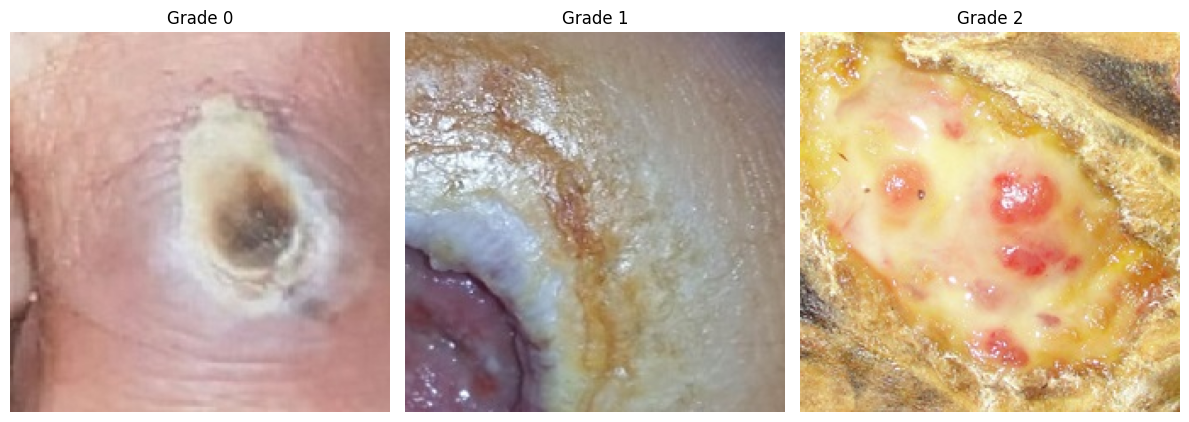

In [ ]:
# Visualize a few sample images
plt.figure(figsize=(12, 6))
for i, cls in enumerate(class_names[:3]):  # Limit to 3 classes for brevity
    cls_dir = os.path.join(train_dir, cls)
    img_name = random.choice(os.listdir(cls_dir))
    img_path = os.path.join(cls_dir, img_name)
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 3: Build and Compile Finetuned Model
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 224, 224,  │          7 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 224, 224,  │          0 │ normalization_4[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_9[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,740,364 (25.71 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 6,575,495 (25.08 MB)

In [ ]:
# Cell 4: Data Preparation with ImageDataGenerator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='reflect',
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.1
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=True
)

# Light augmentation for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1]
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)

# Compute class weights to address Grade 0 bias
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

Found 675 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
# Cell 5: Initial Training (Frozen Layers)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
history_initial = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.2395 - loss: 2.4368 - val_accuracy: 0.3900 - val_loss: 1.6059 - learning_rate: 1.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 339ms/step - accuracy: 0.5118 - loss: 1.6886 - val_accuracy: 0.5800 - val_loss: 1.3267 - learning_rate: 1.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - accuracy: 0.6043 - loss: 1.2797 - val_accuracy: 0.6800 - val_loss: 1.1574 - learning_rate: 1.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.6824 - loss: 1.0980 - val_accuracy: 0.7200 - val_loss: 1.0133 - learning_rate: 1.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 319ms/step - accuracy: 0.7325 - loss: 1.0051 - val_accuracy: 0.8000 - val_loss: 0.9015 - learning_rate: 1.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - accuracy: 0.7313 - loss: 1.0123 - val_accuracy: 0.7500 - val_loss: 0.9082 - learning_rate: 1.0000e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 316ms/step - accura

In [ ]:
# Cell 6: Fine-Tuning (Unfreeze last 30 layers)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=30,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6024 - loss: 1.4372 - val_accuracy: 0.8200 - val_loss: 0.8734 - learning_rate: 1.0000e-05
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 314ms/step - accuracy: 0.6460 - loss: 1.2466 - val_accuracy: 0.7400 - val_loss: 1.0496 - learning_rate: 1.0000e-05
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 317ms/step - accuracy: 0.6515 - loss: 1.1998 - val_accuracy: 0.7300 - val_loss: 0.9907 - learning_rate: 1.0000e-05
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 0.6816 - loss: 1.1722 - val_accuracy: 0.7000 - val_loss: 1.0500 - learning_rate: 1.0000e-05
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - accuracy: 0.6548 - loss: 1.2795 - val_accuracy: 0.7300 - val_loss: 1.0746 - learning_rate: 2.0000e-06
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step - accuracy: 0.6711 - loss: 1.2220 - val_accuracy: 0.6400 - val_loss: 1.2671 - learning_rate: 2.0000e-06
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 318ms/step - accura

In [ ]:
# Combine histories for plotting
history = {
    'accuracy': history_initial.history['accuracy'] + history_fine.history['accuracy'],
    'val_accuracy': history_initial.history['val_accuracy'] + history_fine.history['val_accuracy'],
    'loss': history_initial.history['loss'] + history_fine.history['loss'],
    'val_loss': history_initial.history['val_loss'] + history_fine.history['val_loss']
}

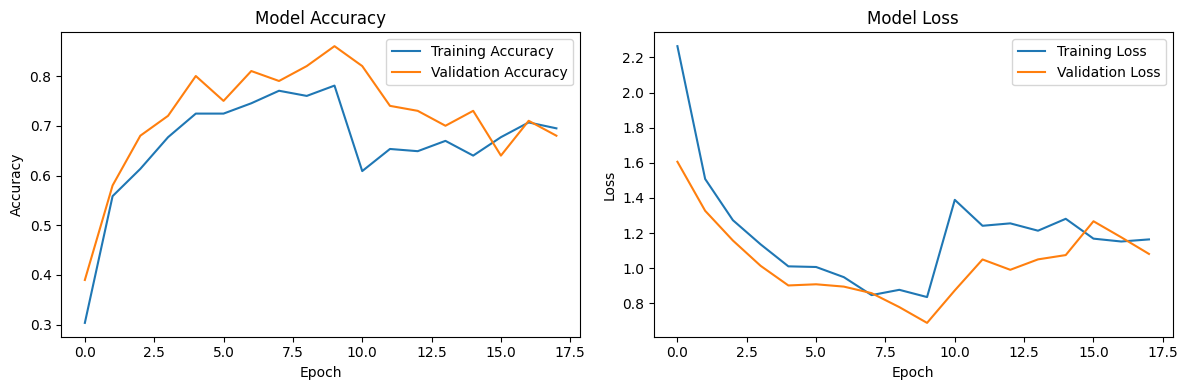

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Cell 7: Evaluate Classifier
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred)]

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Accuracy: 83.00%

Classification Report:

                      precision    recall  f1-score   support

             Grade 0       0.68      0.95      0.79        20
             Grade 1       1.00      0.75      0.86        20
             Grade 2       0.87      0.65      0.74        20
             Grade 3       0.76      0.95      0.84        20
Normal(Healthy skin)       1.00      0.85      0.92        20

            accuracy                           0.83       100
           macro avg       0.86      0.83      0.83       100
        weighted avg       0.86      0.83      0.83       100



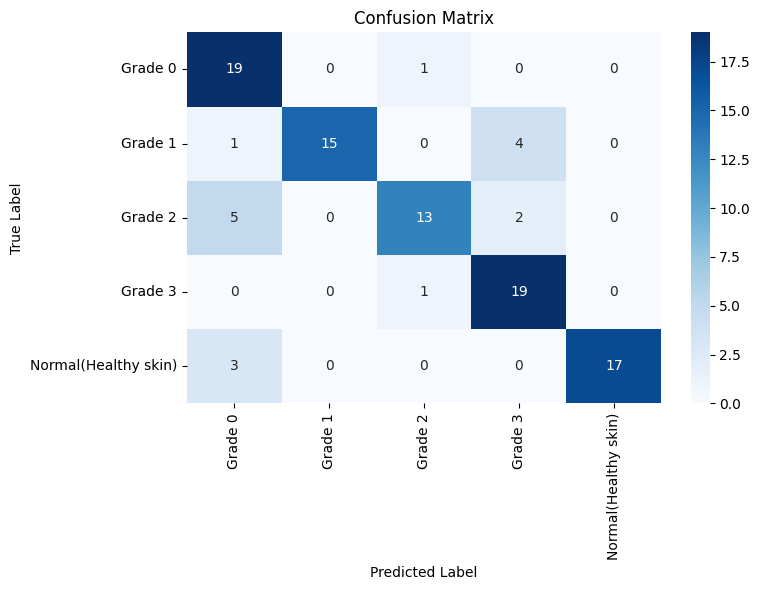

In [ ]:
# Cell 8: Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

<ipython-input-56-676329403>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=label_accuracies, palette='viridis')


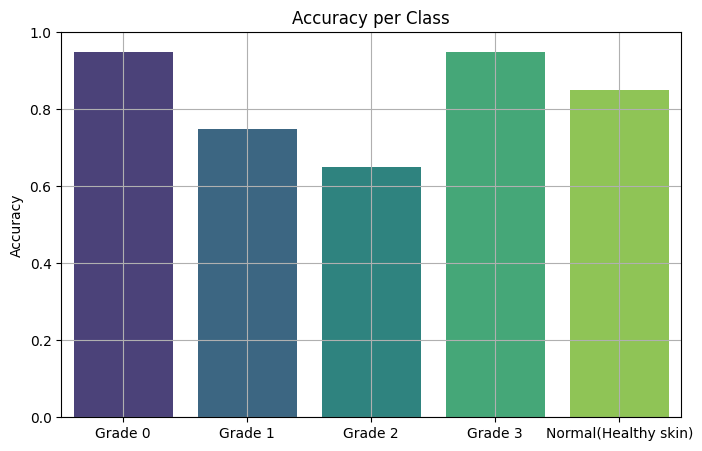

In [ ]:
# Cell 9: Accuracy Bar Plot
correct = (y_pred_classes == y_true)
label_accuracies = []
for i, class_name in enumerate(class_names):
    indices = (y_true == i)
    acc = np.sum(correct[indices]) / np.sum(indices) if np.sum(indices) > 0 else 0
    label_accuracies.append(acc)

plt.figure(figsize=(8, 5))
sns.barplot(x=class_names, y=label_accuracies, palette='viridis')
plt.ylabel("Accuracy")
plt.title("Accuracy per Class")
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()

In [ ]:
# Cell 10: Save Model
model.save("finetuned_efficientnet_v2_84%.h5")
print("Model saved successfully.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


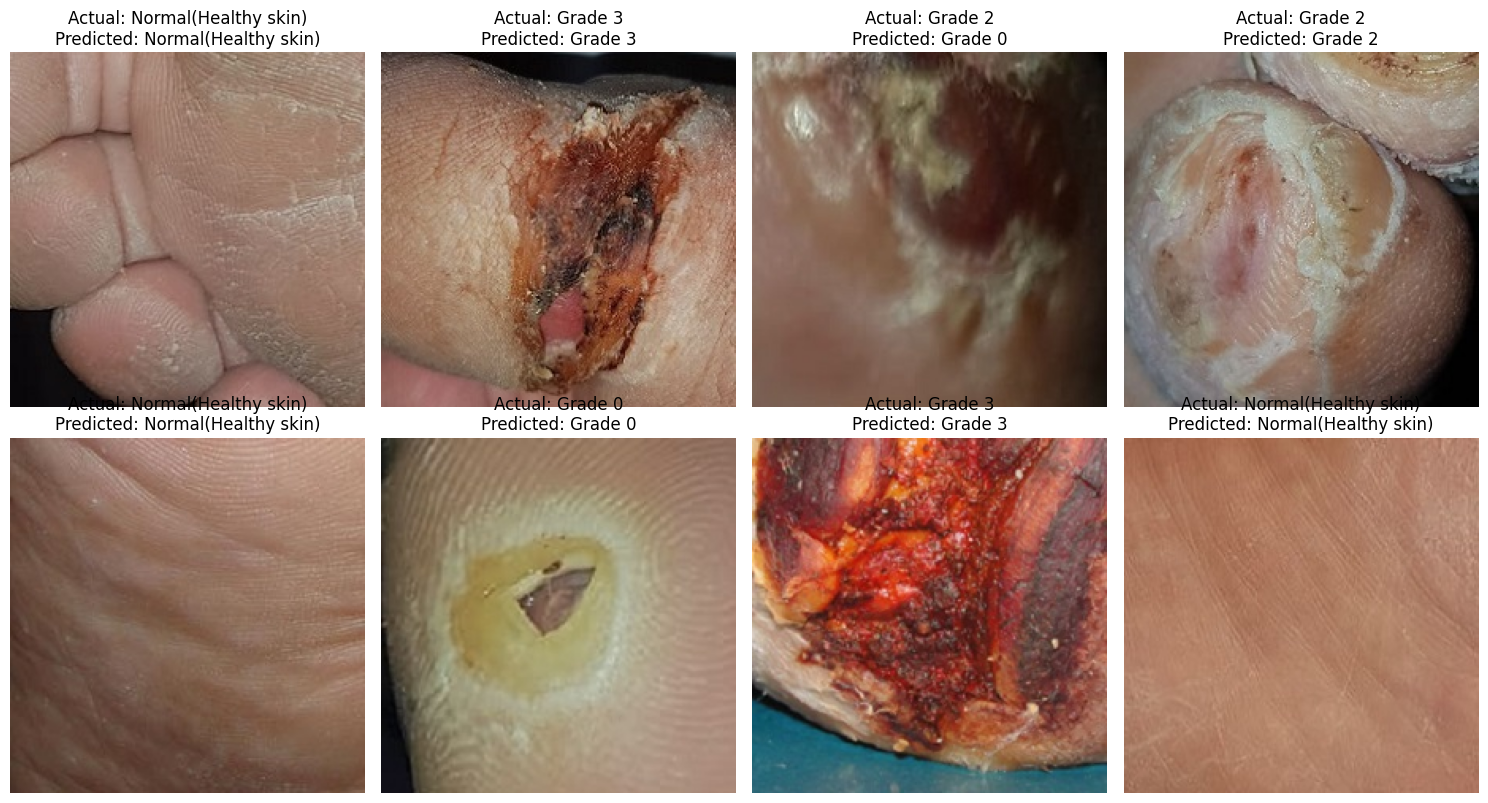

In [ ]:
# Cell 11: Display Predictions on 8 Random Test Images
test_images = [os.path.join(test_dir, cls, img) for cls in os.listdir(test_dir)
               for img in os.listdir(os.path.join(test_dir, cls))]
indices = random.sample(range(len(test_images)), min(8, len(test_images)))
selected_images = [test_images[i] for i in indices]
selected_labels = [class_names.index(os.path.basename(os.path.dirname(img))) for img in selected_images]

selected_images_preprocessed = []
for img_path in selected_images:
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    selected_images_preprocessed.append(x)

X_selected = np.vstack(selected_images_preprocessed)
predictions = np.argmax(model.predict(X_selected), axis=1)

plt.figure(figsize=(15, 8))
for i in range(len(selected_images)):
    img = load_img(selected_images[i], target_size=(224, 224))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    actual = class_names[selected_labels[i]]
    predicted = class_names[predictions[i]]
    plt.title(f"Actual: {actual}\nPredicted: {predicted}")
    plt.axis('off')
plt.tight_layout()
plt.show()